In [1]:
%matplotlib widget

In [2]:
import xtrack as xt

import matplotlib.pyplot as plt

In [3]:
line = xt.Line.from_json('../../xtrack/examples/fcc_ee_solenoid/fccee_z_with_sol.json')

Loading line from dict:   0%|          | 0/81624 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
tw_sol_off = line.twiss4d()

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


## Switch on tilted solenoid

In [5]:
line.vars['on_sol_ip.1'] = 1
tw_sol_on = line.twiss(method='4d')

**Beta beating**

Text(0.5, 0, 's [m]')

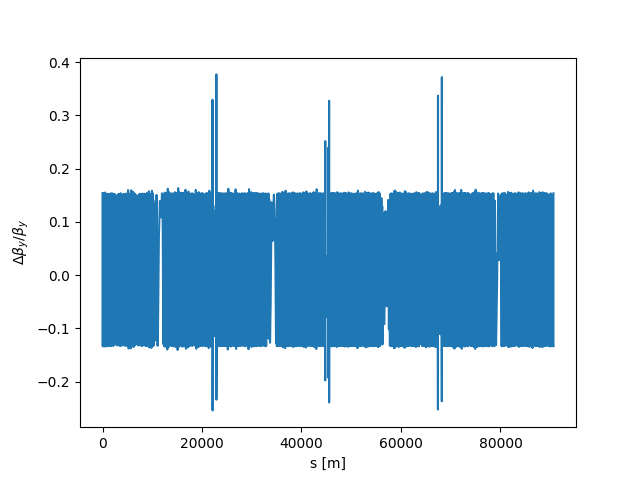

In [6]:
plt.figure()
plt.plot(tw_sol_off.s, tw_sol_on.bety/tw_sol_off.bety - 1)
plt.ylabel(r'$\Delta \beta_y / \beta_y$')
plt.xlabel('s [m]')

In [7]:
tw_sol_on.c_minus

0.00032023365950546956

Text(0, 0.5, 'x [mm]')

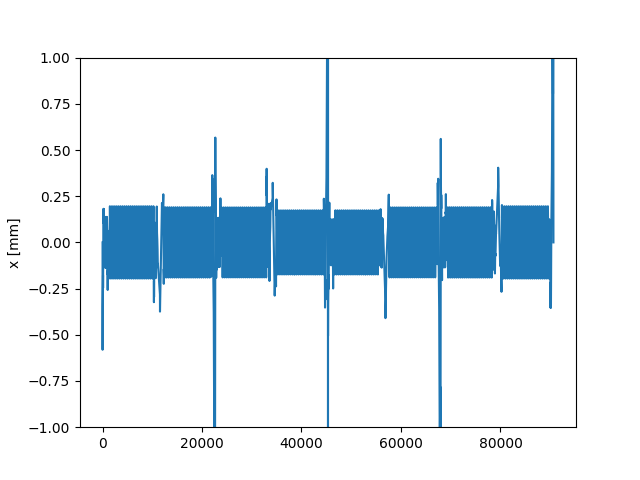

In [8]:
plt.figure()
plt.plot(tw_sol_off.s, tw_sol_on.x*1e3)
plt.ylim(-1, 1)
plt.ylabel('x [mm]')

## Correct locally orbit, coupling and optics

#### Correction strategy for the right side

In [9]:
opt_r = line.match(
    solve=False,
    method='4d', n_steps_max=30,
    start='ip.1', end='pqc2re.1',
    init=tw_sol_off, init_at=xt.END,
    vary=[
        xt.VaryList(['acb1h.r1', 'acb2h.r1','acb1v.r1', 'acb2v.r1'], step=1e-8, tag='corr_r'),            # dipole corr
        xt.VaryList(['ks1.r1', 'ks2.r1', 'ks3.r1', 'ks0.r1'], step=1e-7, tag='skew_r'),                   # skeq quad
        xt.VaryList(['corr_k1.r1', 'corr_k2.r1', 'corr_k3.r1', 'corr_k0.r1'], step=1e-6, tag='normal_r'), # norm quad
    ],
    targets=[
        xt.TargetSet(['x', 'y'], value=tw_sol_off, tol=1e-7, at='ip.1', tag='orbit'),
        xt.TargetSet(['px', 'py'], value=tw_sol_off, tol=1e-10, at='ip.1', tag='orbit'),
        xt.TargetRmatrix(r13=0, r14=0, r23=0, r24=0, # Y-X block
                         r31=0, r32=0, r41=0, r42=0, # X-Y block,
                         start='ip.1', end='pqc2re.1', tol=1e-6, tag='coupl'),
        xt.Target('mux', value=tw_sol_off, at='ip.1', tag='mu_ip', weight=0.1, tol=1e-6),
        xt.Target('muy', value=tw_sol_off, at='ip.1', tag='mu_ip', weight=0.1, tol=1e-6),
        xt.Target('betx', value=tw_sol_off, at='ip.1', tag='bet_ip', weight=1, tol=1e-5),
        xt.Target('bety', value=tw_sol_off, at='ip.1', tag='bet_ip', weight=10, tol=1e-6),
        xt.Target('alfx', value=tw_sol_off, at='ip.1', tag='alf_ip', weight=0.1, tol=1e-4),
        xt.Target('alfy', value=tw_sol_off, at='ip.1', tag='alf_ip', weight=0.1, tol=1e-4),

    ]
)

Found suitable prebuilt kernel `only_xtrack_backtrack_frozen_energy`.


In [10]:
opt_r.target_status()

Target status:                          
id state tag    tol_met      residue  current_val   target_val description                                 
 0 ON    orbit    False -2.29394e-06 -2.29394e-06 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 ON    orbit     True -2.82132e-10 -2.82132e-10            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 ON    orbit    False   1.6033e-06     0.015001    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 ON    orbit    False  1.84498e-06  1.84498e-06            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 ON    coupl    False  0.000344809  0.000344809            0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
 5 ON    coupl    False   0.00154466   0.00154466            0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
 6 ON    coupl    False  -2.2125e-05  -2.2125e-05            0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
 7 ON    coupl    False -5.52266e-05 -5.52266e-05            0 r24(ip.1, pqc2re.1, val=0, tol=1

#### Match orbit alone

In [11]:
# Enable only orbit targets
opt_r.disable_all_targets();
opt_r.enable_targets(tag='orbit'); 
opt_r.target_status()

Target status:                          
id state tag    tol_met      residue  current_val   target_val description                                 
 0 ON    orbit    False -2.29394e-06 -2.29394e-06 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 ON    orbit     True -2.82132e-10 -2.82132e-10            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 ON    orbit    False   1.6033e-06     0.015001    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 ON    orbit    False  1.84498e-06  1.84498e-06            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 OFF   coupl    False            0  0.000344809            0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
 5 OFF   coupl    False            0   0.00154466            0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
 6 OFF   coupl    False            0  -2.2125e-05            0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
 7 OFF   coupl    False            0 -5.52266e-05            0 r24(ip.1, pqc2re.1, val=0, tol=1

In [13]:
# Enable dipole corrector knobs
opt_r.enable_vary(tag='corr_r')
opt_r.vary_status()

Vary status:                 
id state tag      name       lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON    corr_r   acb1h.r1          None           0        None             0 1e-08      1
 1 ON    corr_r   acb2h.r1          None           0        None             0 1e-08      1
 2 ON    corr_r   acb1v.r1          None           0        None             0 1e-08      1
 3 ON    corr_r   acb2v.r1          None           0        None             0 1e-08      1
 4 ON    skew_r   ks1.r1            None           0        None             0 1e-07      1
 5 ON    skew_r   ks2.r1            None           0        None             0 1e-07      1
 6 ON    skew_r   ks3.r1            None           0        None             0 1e-07      1
 7 ON    skew_r   ks0.r1            None           0        None             0 1e-07      1
 8 ON    normal_r corr_k1.r1        None           0        None             0 1e-06      1
 9 ON    normal_r corr_k2.r1        None          

In [14]:
# Solve
opt_r.solve()
opt_r.target_status()

Matching: model call n. 16               

Target status:                           
id state tag    tol_met      residue  current_val   target_val description                                 
 0 ON    orbit     True -5.47745e-14 -5.48187e-14 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 ON    orbit     True -6.35875e-14 -6.35875e-14            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 ON    orbit     True -4.74065e-14    0.0149994    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 ON    orbit     True  6.81504e-17  6.81504e-17            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 OFF   coupl    False            0  0.000344961            0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
 5 OFF   coupl    False            0   0.00154432            0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
 6 OFF   coupl    False            0 -2.21276e-05            0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
 7 OFF   coupl    False            0 -5.52142e-05  

#### Match coupling alone

In [15]:
opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_targets(tag='coupl'); opt_r.enable_vary(tag='skew_r');
opt_r.solve()
opt_r.target_status()

Matching: model call n. 225               

Target status:                            
id state tag    tol_met      residue  current_val   target_val description                                 
 0 OFF   orbit     True            0  3.14586e-09 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 OFF   orbit     True            0   8.4273e-10            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 OFF   orbit    False            0    0.0149994    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 OFF   orbit     True            0  9.69516e-12            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 ON    coupl     True  2.72406e-07  2.72406e-07            0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
 5 ON    coupl     True -1.01584e-08 -1.01584e-08            0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
 6 ON    coupl     True -9.20373e-09 -9.20373e-09            0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
 7 ON    coupl     True  2.72012e-10  2.72012e-10

#### Match optics alone ($\mu_{x, y}$,$\beta_{x, y}$, $\alpha_{x, y}$)

In [16]:
# phase, beta and alpha alone
opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_vary(tag='normal_r')
opt_r.enable_targets(tag='mu_ip'); opt_r.solve()
opt_r.enable_targets(tag='bet_ip'); opt_r.solve()
opt_r.enable_targets(tag='alf_ip'); opt_r.solve()

Matching: model call n. 238               

Matching: model call n. 250               

Matching: model call n. 251               



In [17]:
opt_r.enable_all_targets()
opt_r.target_status()

Target status:                            
id state tag    tol_met      residue  current_val   target_val description                                 
 0 ON    orbit     True  3.25906e-09  3.25906e-09 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 ON    orbit     True  6.55868e-10  6.55868e-10            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 ON    orbit    False -4.84559e-10    0.0149994    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 ON    orbit     True  6.32184e-11  6.32184e-11            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 ON    coupl     True  6.34398e-07  6.34398e-07            0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
 5 ON    coupl     True -1.00689e-07 -1.00689e-07            0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
 6 ON    coupl     True -4.31629e-09 -4.31629e-09            0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
 7 ON    coupl     True  6.71563e-09  6.71563e-09            0 r24(ip.1, pqc2re.1, val=0, tol

### Another iteration to refine the solution

In [18]:
opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_targets(tag='orbit'); opt_r.enable_vary(tag='corr_r'); opt_r.solve()

opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_targets(tag='coupl'); opt_r.enable_vary(tag='skew_r'); opt_r.solve()

opt_r.disable_all_targets(); opt_r.disable_all_vary()
opt_r.enable_vary(tag='normal_r')
opt_r.enable_targets(tag='mu_ip'); opt_r.solve()
opt_r.enable_targets(tag='bet_ip'); opt_r.solve()
opt_r.enable_targets(tag='alf_ip'); opt_r.solve()


Matching: model call n. 258               

Matching: model call n. 259               

Matching: model call n. 260               

Matching: model call n. 261               

Matching: model call n. 262               



In [19]:
# Inspect the result
opt_r.enable_all_targets()
opt_r.target_status()

Target status:                            
id state tag    tol_met      residue  current_val   target_val description                                 
 0 ON    orbit     True -1.10338e-16 -1.54547e-16 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 ON    orbit     True -4.15464e-19 -4.15464e-19            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 ON    orbit     True  3.64292e-17    0.0149994    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 ON    orbit     True -1.60407e-20 -1.60407e-20            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 ON    coupl     True  6.88362e-07  6.88362e-07            0 r13(ip.1, pqc2re.1, val=0, tol=1e-06, we ...
 5 ON    coupl     True -1.00711e-07 -1.00711e-07            0 r14(ip.1, pqc2re.1, val=0, tol=9.9999999 ...
 6 ON    coupl     True   2.2739e-10   2.2739e-10            0 r23(ip.1, pqc2re.1, val=0, tol=1e-08, we ...
 7 ON    coupl     True  6.72072e-09  6.72072e-09            0 r24(ip.1, pqc2re.1, val=0, tol

In [20]:
# Inspect the knobs
opt_r.vary_status()

Vary status:                 
id state tag      name       lower_limit  current_val upper_limit val_at_iter_0  step weight
 0 OFF   corr_r   acb1h.r1          None  -3.9892e-06        None             0 1e-08      1
 1 OFF   corr_r   acb2h.r1          None  1.76496e-06        None             0 1e-08      1
 2 OFF   corr_r   acb1v.r1          None  4.37252e-06        None             0 1e-08      1
 3 OFF   corr_r   acb2v.r1          None -3.99763e-06        None             0 1e-08      1
 4 OFF   skew_r   ks1.r1            None  0.000616639        None             0 1e-07      1
 5 OFF   skew_r   ks2.r1            None -0.000328845        None             0 1e-07      1
 6 OFF   skew_r   ks3.r1            None -0.000771263        None             0 1e-07      1
 7 OFF   skew_r   ks0.r1            None  0.000718992        None             0 1e-07      1
 8 ON    normal_r corr_k1.r1        None  -6.9131e-05        None             0 1e-06      1
 9 ON    normal_r corr_k2.r1        None

In [22]:
opt_l = line.match(
    solve=False, method='4d', n_steps_max=30,
    start='pqc2le.4', end='ip.1', init=tw_sol_off, init_at=xt.START,
    vary=[xt.VaryList(['acb1h.l1', 'acb2h.l1','acb1v.l1', 'acb2v.l1'], step=1e-8, tag='corr_l'),
          xt.VaryList(['ks1.l1', 'ks2.l1', 'ks3.l1', 'ks0.l1'], step=1e-7, tag='skew_l'),
          xt.VaryList(['corr_k1.l1', 'corr_k2.l1', 'corr_k3.l1', 'corr_k0.l1'], step=1e-6, tag='normal_l')],
    targets=[
        xt.TargetSet(['x', 'y'], value=tw_sol_off, tol=1e-7, at='ip.1', tag='orbit'),
        xt.TargetSet(['px', 'py'], value=tw_sol_off, tol=1e-10, at='ip.1', tag='orbit'),
        xt.TargetRmatrix(r13=0, r14=0, r23=0, r24=0, r31=0, r32=0, r41=0, r42=0,
                         start='pqc2le.4', end='ip.1', tol=1e-6, tag='coupl'),
        xt.Target('mux', value=tw_sol_off, at='ip.1', tag='mu_ip', weight=0.1, tol=1e-6),
        xt.Target('muy', value=tw_sol_off, at='ip.1', tag='mu_ip', weight=0.1, tol=1e-6),
        xt.Target('betx', value=tw_sol_off, at='ip.1', tag='bet_ip', weight=1, tol=1e-5),
        xt.Target('bety', value=tw_sol_off, at='ip.1', tag='bet_ip', weight=10, tol=1e-6),
        xt.Target('alfx', value=tw_sol_off, at='ip.1', tag='alf_ip', weight=0.1, tol=1e-4),
        xt.Target('alfy', value=tw_sol_off, at='ip.1', tag='alf_ip', weight=0.1, tol=1e-4),])

for iter in range(2):
    opt_l.disable_all_targets(); opt_l.disable_all_vary()
    opt_l.enable_targets(tag='orbit'); opt_l.enable_vary(tag='corr_l'); opt_l.solve()
    opt_l.disable_all_targets(); opt_l.disable_all_vary()
    opt_l.enable_targets(tag='coupl'); opt_l.enable_vary(tag='skew_l'); opt_l.solve()
    opt_l.disable_all_targets(); opt_l.disable_all_vary()
    opt_l.enable_vary(tag='normal_l')
    opt_l.enable_targets(tag='mu_ip'); opt_l.solve()
    opt_l.enable_targets(tag='bet_ip'); opt_l.solve()
    opt_l.enable_targets(tag='alf_ip'); opt_l.solve()

Matching: model call n. 6               

Matching: model call n. 36               

Matching: model call n. 48               

Matching: model call n. 60               

Matching: model call n. 61               

Matching: model call n. 67               

Matching: model call n. 73               

Matching: model call n. 74               

Matching: model call n. 75               

Matching: model call n. 76               



In [23]:
opt_l.enable_all_targets(); opt_l.enable_all_vary()
opt_l.target_status()
opt_l.vary_status()

Target status:                           
id state tag    tol_met      residue  current_val   target_val description                                 
 0 ON    orbit     True  5.12919e-13  5.12875e-13 -4.42083e-17 ('x', 'ip.1'), val=-4.42083e-17, tol=1e- ...
 1 ON    orbit     True -1.26277e-13 -1.26277e-13            0 ('y', 'ip.1'), val=0, tol=1e-07, weight= ...
 2 ON    orbit     True   4.4631e-14    0.0149994    0.0149994 ('px', 'ip.1'), val=0.0149994, tol=1e-10 ...
 3 ON    orbit     True  1.84152e-14  1.84152e-14            0 ('py', 'ip.1'), val=0, tol=1e-10, weight ...
 4 ON    coupl     True -2.13746e-10 -2.13746e-10            0 r13(pqc2le.4, ip.1, val=0, tol=1e-06, we ...
 5 ON    coupl     True  2.85943e-09  2.85943e-09            0 r14(pqc2le.4, ip.1, val=0, tol=9.9999999 ...
 6 ON    coupl     True  6.18145e-11  6.18145e-11            0 r23(pqc2le.4, ip.1, val=0, tol=1e-08, we ...
 7 ON    coupl     True -2.40307e-08 -2.40307e-08            0 r24(pqc2le.4, ip.1, val=0, tol=

## Plot results

In [24]:
tw_sol_on_corrected = line.twiss(method='4d')

Text(0.5, 0, 's [m]')

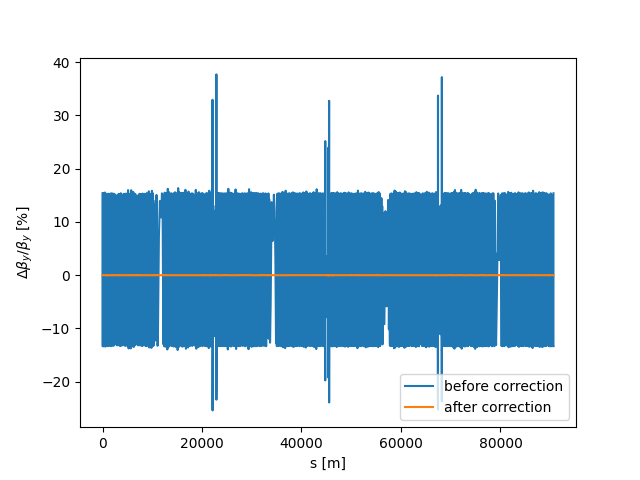

In [25]:
plt.figure()
plt.plot(tw_sol_on.s, 100 * (tw_sol_on.bety/tw_sol_off.bety - 1), label='before correction')
plt.plot(tw_sol_on.s, 100 * (tw_sol_on_corrected.bety/tw_sol_off.bety - 1), label='after correction')
plt.ylabel(r'$\Delta \beta_y / \beta_y$ [%]')
plt.legend()
plt.xlabel('s [m]')

|C-| before:  0.00032023365950546956
|C-| after :  7.233367683979665e-07


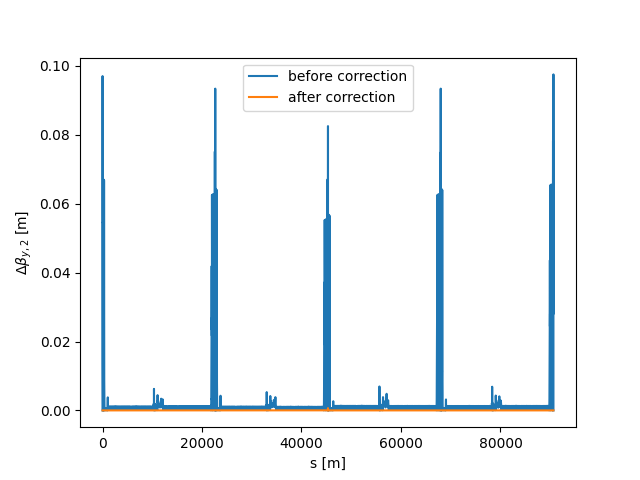

In [26]:
# Coupling
plt.figure()
plt.plot(tw_sol_on.s, tw_sol_on.bety1, label='before correction')
plt.plot(tw_sol_on.s, tw_sol_on_corrected.bety1, label='after correction')
plt.ylabel(r'$\Delta \beta_{y,2}$ [m]')
plt.legend()
plt.xlabel('s [m]')

print('|C-| before: ', tw_sol_on.c_minus)
print('|C-| after : ', tw_sol_on_corrected.c_minus)

Text(0.5, 0, 's [m]')

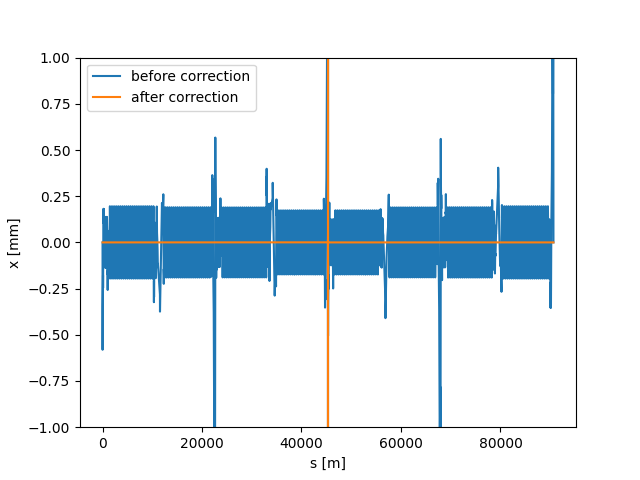

In [27]:
# Orbit
plt.figure()
plt.plot(tw_sol_on.s, 1000 * tw_sol_on.x, label='before correction')
plt.plot(tw_sol_on.s, 1000 * tw_sol_on_corrected.x, label='after correction')
plt.ylabel(r'x [mm]')
plt.ylim(-1,1)
plt.legend()
plt.xlabel('s [m]')